<center> <h1><b>Email Spam Detection </center>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/spam mail.csv')
df.info()

### Step1:Data Preprosessing


1.   use Limmatizer to reduce words to their base or root form
2.   Use NLTK's POS tagger to get the POS tag of a word
3.   Convert to Lowercase
4.   Remove Punctuation
5.   Remove Non-ASCII Characters
6.   Remove Numeric Values
7.   Tokenize and Remove Stop Words
8.   Remove Duplicates




In [76]:
import string
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove numeric values
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(tokens)



# Remove duplicates
df.drop_duplicates(inplace=True)

# Apply the preprocessing function to the 'Messages' column
df['Cleaned_Messages'] = df['Masseges'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Category,Masseges,Cleaned_Messages
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


### Step 2: Feature Extraction


1.   Split Dataset into Training and Testing Sets
2.   convert the text data into numerical features using TF-IDF




In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Masseges'], df['Category'], test_size=0.2, random_state=42,stratify=y)
# Feature extraction using TF-IDF with bigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Display the shape of the TF-IDF matrices
X_train_tfidf.shape, X_test_tfidf.shape


((4135, 5000), (1034, 5000))

### Step 3: Model Building
train a machine learning model on the features. I  used a Naive Bayes classifier.


In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
# Hyperparameter tuning using Grid Search
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test_tfidf)


### Step 4: Model Evaluation
Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.



In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

best_params, best_score, accuracy, precision, recall, f1

({'alpha': 0.1},
 0.9850060459492139,
 0.9845261121856866,
 0.9752066115702479,
 0.9007633587786259,
 0.9365079365079365)

### step 5 : visualize the exploratory the data analysis

1.   Visualize the distribution of spam and ham messages
2.   Word Cloud for spam and ham messages
3.   Distribution of message lengths



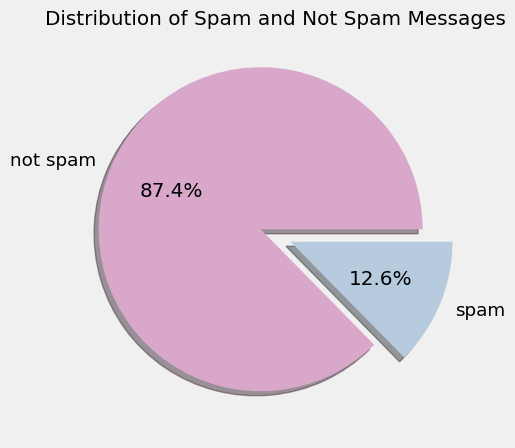

In [80]:
#  Visualize the distribution of spam and ham messages

category_counts = df['Category'].value_counts()
plt.style.use('fivethirtyeight')
colors = ['#D8A7CA', '#B6CBDE']
explode = [0.1, 0.1]
plt.figure(figsize=(5, 5))
sns.set_context('notebook', font_scale=1.2)
plt.pie(category_counts, labels=['not spam', 'spam'], explode=explode, shadow=True, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Spam and Not Spam Messages')
plt.show()


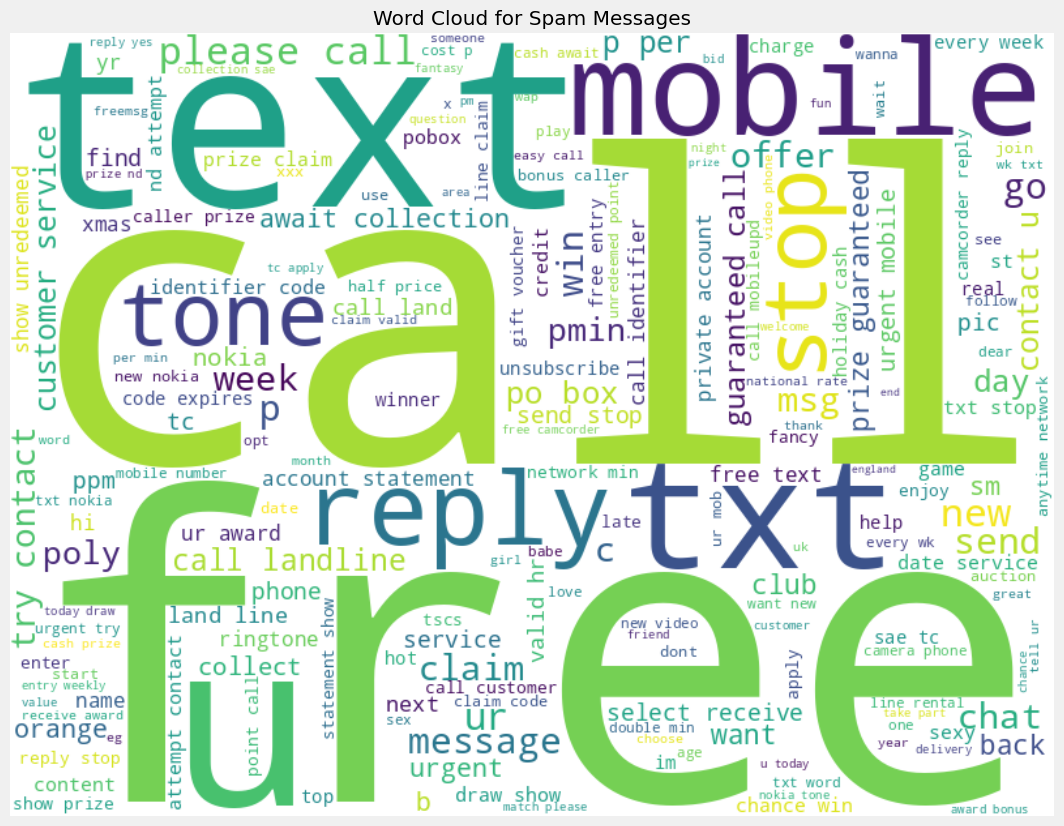

In [87]:
# Create word clouds for spam
spam_text = ' '.join(df[df['Category'] == 'spam']['Cleaned_Messages'])
not_spam_text = ' '.join(df[df['Category'] == 'ham']['Cleaned_Messages'])

spam_wc = WordCloud(width=800, height=600, background_color='white').generate(spam_text)


# Plot the word cloud for spam messages
plt.figure(figsize=(12, 10))
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.show()


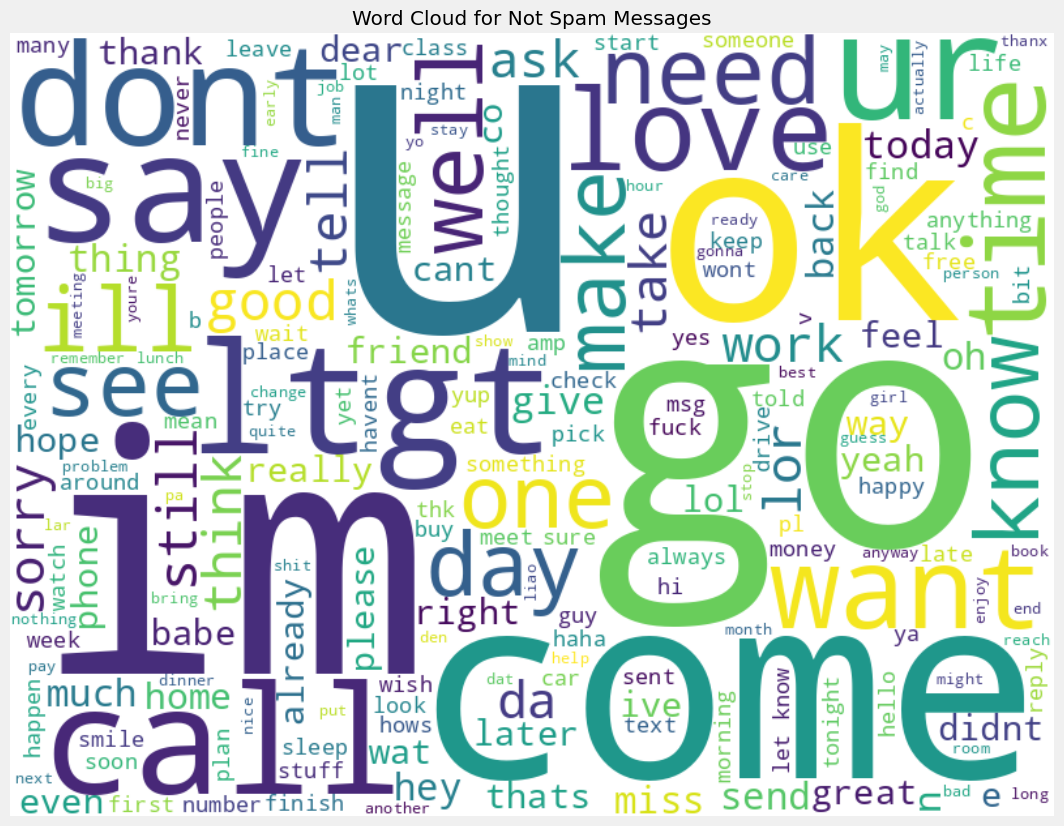

In [82]:
# Word Cloud for not spam messages
not_spam_wc = WordCloud(width=800, height=600, background_color='white').generate(not_spam_text)

plt.figure(figsize=(12, 10))
plt.imshow(not_spam_wc, interpolation='bilinear')
plt.title('Word Cloud for Not Spam Messages')
plt.axis('off')
plt.show()

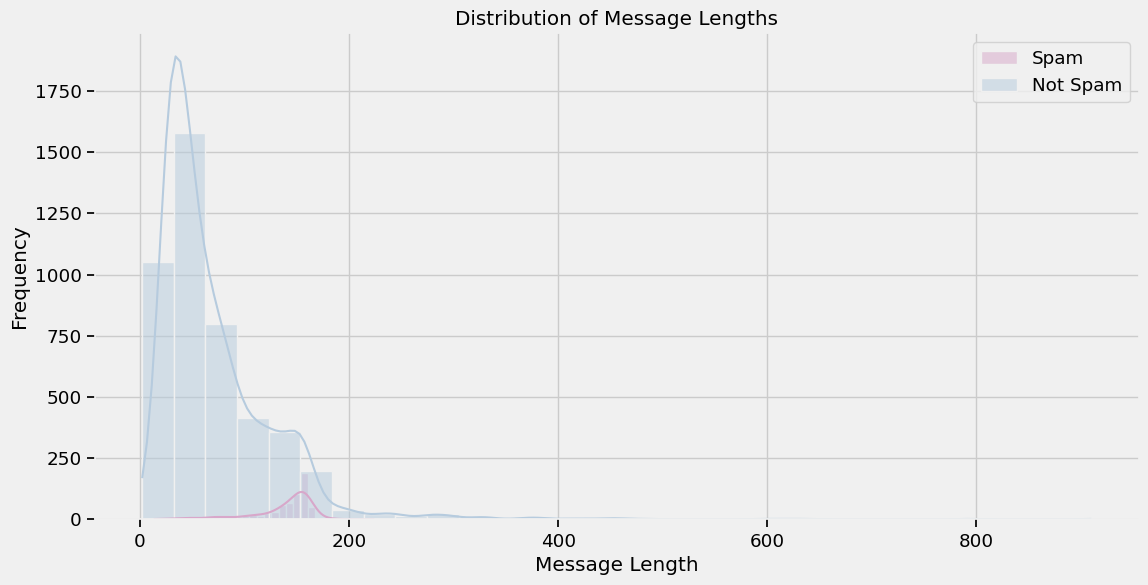

In [83]:
# 3. Distribution of message lengths
df['Message_Length'] = df['Masseges'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df[df['Category'] == 'spam']['Message_Length'], bins=30, color='#D8A7CA', label='Spam', kde=True)
sns.histplot(df[df['Category'] == 'ham']['Message_Length'], bins=30, color='#B6CBDE', label='Not Spam', kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [84]:
with open('spam_classifier.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [88]:
import ipywidgets as widgets
from IPython.display import display
import pickle
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the model and vectorizer
with open('spam_classifier.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove numeric values
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(tokens)

# Function to predict spam
def predict_spam(message):
    if message:
        processed_message = preprocess_text(message)
        message_tfidf = vectorizer.transform([processed_message])
        prediction = model.predict(message_tfidf)
        if prediction == 'spam':
            result = "This message is Spam."
        else:
            result = "This message is not Spam."
        return result
    else:
        return "Please enter a message."

# Create widgets
input_text = widgets.Textarea(
    value='',
    placeholder='Type your message here',
    description='Message:',
    disabled=False
)

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        message = input_text.value
        result = predict_spam(message)
        print(result)

button = widgets.Button(
    description='Predict Spam',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)
button.on_click(on_button_click)

# Display widgets
display(input_text, button, output)


Textarea(value='', description='Message:', placeholder='Type your message here')

Button(description='Predict Spam', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()